# Selecting data based on spatial relationships

In this new notebook about learning GIS, we will dive into data selection based on spatial relationships. When working with geospatial data, you often need to do specific GIS operations based on how the data layers are located in relation to each other. For instance, finding out if a certain point is located inside an area, or whether a line intersects with another line or a polygon, are very common operations for selecting data based on spatial location.

These kind of queries are commonly called as **spatial queries**. Spatial queries are conducted based on the topological spatial relations which are fundamental constructs that describe how two or more geometric objects relate to each other concerning their position and boundaries. Topological spatial relations can be exemplified by relationships such as contains, touches and intersects. In GIS, the topological relations play a crucial role as they enable queries that are less concerned with the exact coordinates or shapes of geographic entities but more focused on their relative arrangements and positions. 

#### Making spatial queries in Python

Spatial queries using Python are implemented in **shapely** and **geopandas**, including:
- .intersects()
- .within()
- .contains()
- .overlaps()
- .touches()
- .covers()
- .covered_by()
- .equals()
- .disjoint()
- .crosses()

To use Python to find out how two geometric objects are related to each other topologically, you start by creating the geometries using **shapely** library. 

In the following, we create a couple of Point objects and one Polygon object which we can use to test how they relate to each other:

In [1]:
# Import libraries
from shapely import Point, Polygon

# Create point objects
point1 = Point(24.952242, 60.1696017)
point2 = Point(24.976567, 60.1612500)

# Create a Polygon
coordinates = [
    (24.950899, 60.169158),
    (24.953492, 60.169158),
    (24.953510, 60.170104),
    (24.950958, 60.169990)
]

polygon = Polygon(coordinates)


In [2]:
# Check the created geometries
print(point1)
print(point2)
print(polygon)


POINT (24.952242 60.1696017)
POINT (24.976567 60.16125)
POLYGON ((24.950899 60.169158, 24.953492 60.169158, 24.95351 60.170104, 24.950958 60.16999, 24.950899 60.169158))


Considering the coordinates, we can test whether the Point geometries stored in point1 and point2 are within the polygon, by calling the *.within()* method as follows:

In [ ]:
# Is point 1 within the polygon?
point1.within(polygon)

True

In [4]:
# Is point 2 within the polygon?
point2.within(polygon)

False

So, point1 is within the polygon, but point2 is not.


One of the most common spatial queries is to see if a geometry intersects or touches another one. Again, there are binary operations in shapely for checking these spatial relationships:

- *.intersects()* - Two objects intersect if the boundary or interior of one object intersect in any way with the boundary or interior of the other object.

- *.touches()* - Two objects touch if the objects have at least one point in common and their interiors do not intersect with any part of the other object.

Let’s try these by creating two LineString geometries and test whether they intersect and touch each other:

In [5]:
# Import needed modules
from shapely import LineString, MultiLineString

# Create two lines
line_a = LineString([(0, 0), (1, 1)])
line_b = LineString([(1, 1), (0, 2)])

In [7]:
# Do they intersect?
line_a.intersects(line_b)

True

In [8]:
# Do they touch?
line_a.touches(line_b)

True

Both lines touch and intersect. We can plot them to check it again:

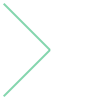

In [11]:
# Create a multilinestring from both lines
multi_line = MultiLineString([line_a, line_b])
multi_line

#### Spatial queries using geopandas